# ARVATO CAPSTONE PROJECT 

# UDACITY

### BY AMAR SINGH ----------------------------------------------------------------------------------------------                                                                                                            DATE: 13-07-2020

# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cluster , datasets, mixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import adjusted_rand_score , accuracy_score , confusion_matrix
from sklearn.decomposition import PCA,FastICA
from sklearn.preprocessing import StandardScaler



# magic word for producing visualizations in notebook
%matplotlib inline



## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data

#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [112]:
azdias1 = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Load in the general demographics data.
#azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=";")

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=";")

In [5]:
# Prepare array of strings containing X for parsing 
dsfs

NameError: name 'dsfs' is not defined

In [113]:
feat_info_attr = feat_info.attribute.tolist()
azdias_attr = azdias1.columns.tolist()
#customer_attr =customers.columns.tolist()

In [ ]:
col = list(set(customer_attr) - set(azdias_attr))
print(col)
customers.drop(col,axis=1,inplace=True)

In [ ]:
non_feature_col = list(set(azdias_attr) - set(feat_info_attr))

customers.drop(non_feature_col,axis=1,inplace=True)

In [ ]:
azdias.drop(non_feature_col,axis=1,inplace=True)

In [ ]:
azdias.to_csv('azdias_initial.csv')

In [ ]:
customers.to_csv('customers.csv')

In [6]:
azdias =pd.read_csv('azdias_initial.csv')
azdias = azdias.drop('Unnamed: 0',axis=1)

In [7]:
customers =pd.read_csv('customers.csv')
customers = customers.drop('Unnamed: 0',axis=1)

In [8]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTER_HH                 817722 non-null float64
ANZ_HAUSHALTE_AKTIV      798073 non-null float64
ANZ_HH_TITEL             794213 non-null float64
ANZ_PERSONEN             817722 non-null float64
ANZ_TITEL                817722 non-null float64
ARBEIT                   794005 non-null float64
BALLRAUM                 797481 non-null float64
CAMEO_DEU_2015           792242 non-null object
CAMEO_DEUG_2015          792242 non-null object
CAMEO_INTL_2015          792242 non-null object
CJT_GESAMTTYP            886367 non-null float64
EWDICHTE                 797481 non-null float64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_VORSORGER      

In [9]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 85 columns):
AGER_TYP                 191652 non-null int64
ALTER_HH                 145056 non-null float64
ANZ_HAUSHALTE_AKTIV      141725 non-null float64
ANZ_HH_TITEL             139542 non-null float64
ANZ_PERSONEN             145056 non-null float64
ANZ_TITEL                145056 non-null float64
ARBEIT                   141176 non-null float64
BALLRAUM                 141693 non-null float64
CAMEO_DEU_2015           141224 non-null object
CAMEO_DEUG_2015          141224 non-null object
CAMEO_INTL_2015          141224 non-null object
CJT_GESAMTTYP            188439 non-null float64
EWDICHTE                 141693 non-null float64
FINANZ_ANLEGER           191652 non-null int64
FINANZ_HAUSBAUER         191652 non-null int64
FINANZ_MINIMALIST        191652 non-null int64
FINANZ_SPARER            191652 non-null int64
FINANZ_UNAUFFAELLIGER    191652 non-null int64
FINANZ_VORSORGER      

In [10]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,...,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,NaN,NaN,-1,NaN,NaN,NaN,3,1,2
1,-1,0.0,11.0,0.0,2.0,0.0,3.0,6.0,8A,8.0,...,3,1.0,0.0,2,3.0,9.0,4.0,5,2,1
2,-1,17.0,10.0,0.0,1.0,0.0,3.0,2.0,4C,4.0,...,2,0.0,0.0,1,3.0,9.0,2.0,5,2,3
3,2,13.0,1.0,0.0,0.0,0.0,2.0,4.0,2A,2.0,...,1,0.0,0.0,1,NaN,9.0,7.0,3,2,4
4,-1,20.0,3.0,0.0,4.0,0.0,4.0,2.0,6B,6.0,...,2,0.0,0.0,2,2.0,9.0,3.0,4,1,3


In [11]:
feat_info.head(40)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [12]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [ ]:
# Identify missing or unknown data values and convert them to NaNs.
## for missing vallue encoded as [0]:
#zero_missing = ['CJT_GESAMTTYP','LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','LP_FAMILIE_FEIN','LP_FAMILIE_GROB','LP_STATUS_FEIN','LP_STATUS_GROB','GEBURTSJAHR','RETOURTYP_BK_S']
#azdias[zero_missing] = azdias[zero_missing].replace(0,np.nan)


In [ ]:
## for missing value encoded as [-1]:
#min_one_miss = ['FINANZ_MINIMALIST','FINANZ_SPARER','FINANZ_VORSORGER','FINANZ_ANLEGER','FINANZ_UNAUFFAELLIGER','FINANZ_HAUSBAUER','FINANZTYP','SHOPPER_TYP','SOHO_KZ']
#azdias[min_one_miss] = azdias[min_one_miss].replace(-1,np.nan)

In [ ]:
#zero_one = ['AGER_TYP','ANREDE_KZ','HEALTH_TYP','NATIONALITAET_KZ','PRAEGENDE_JUGENDJAHRE']
#azdias[zero_one] = azdias[zero_one].replace([0,-1],np.nan)

In [ ]:
#one_nine = ['SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL','SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST','SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM','SEMIO_PFLICHT', 'SEMIO_TRADV']
#azdias[one_nine] = azdias[one_nine].replace([9,-1],np.nan)

In [ ]:
#mix_missing = ['ALTERSKATEGORIE_GROB']
#azdias[mix_missing] = azdias[mix_missing].replace([9,-1,0],np.nan)

In [ ]:
#mis= ['GFK_URLAUBERTYP','GREEN_AVANTGARDE'] 
#azdias[mis] = azdias[mis].replace('',np.nan)

In [13]:
def missing_to_nan(data):
    for i,j in enumerate(data.iteritems()):
        missing_unknown = feat_info['missing_or_unknown'][i]
        column_name_miss = j[0]
        missing_unknown = missing_unknown[1:-1].split(',')
        if missing_unknown != ['']:
            replaced = []
            for k in missing_unknown:
                if k in ['X','XX']:
                    replaced.append(k)
                else:
                    replaced.append(int(k))
            data[column_name_miss] = data[column_name_miss].replace(replaced,np.nan)
            
    return data

In [14]:
azdias=missing_to_nan(azdias)

In [15]:
df = azdias.isnull().sum()

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [16]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
df.value_counts().sort_values(ascending=False)

0         25
4854       8
133324     7
116515     5
73499      5
93148      4
111196     3
93740      3
98979      3
121196     2
97216      2
147988     1
108315     1
685843     1
867252     1
97274      1
236309     1
99611      1
333084     1
392318     1
2881       1
584612     1
148092     1
18348      1
105807     1
97632      1
93155      1
73969      1
121985     1
dtype: int64

Text(0,0.5,'Missing Counts in Columns')

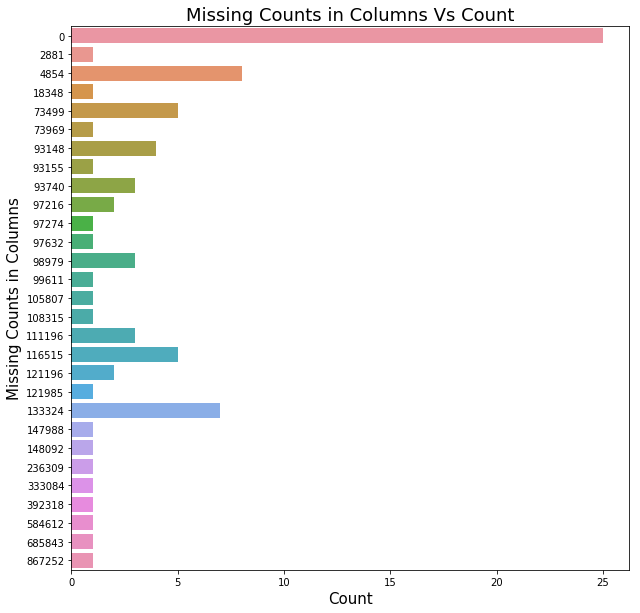

In [17]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize=[10,10])
sns.countplot(y =df.sort_values(ascending=True))
plt.title("Missing Counts in Columns Vs Count",size=18)
plt.xlabel("Count",size=15)
plt.ylabel("Missing Counts in Columns",size=15)

Text(0,0.5,'Counts')

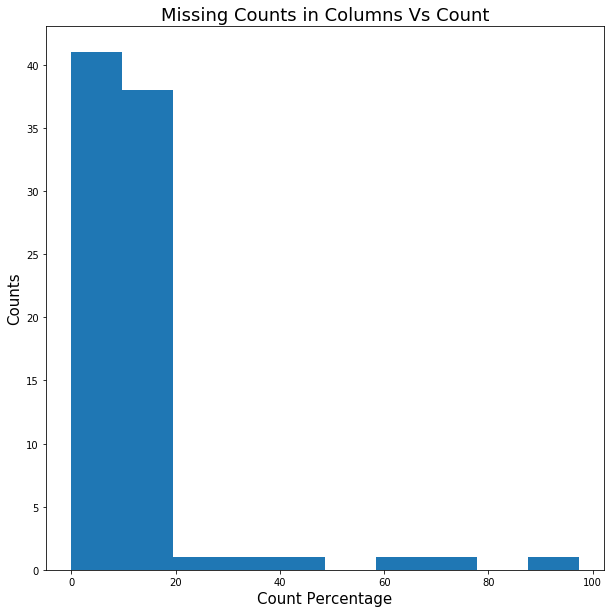

In [18]:
plt.figure(figsize=[10,10])
plt.hist(df*100/azdias.shape[0],bins=10)
plt.title("Missing Counts in Columns Vs Count",size=18)
plt.xlabel("Count Percentage",size=15)
plt.ylabel("Counts",size=15)

In [19]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
df_to_be_clean=df[df>159000]

df_to_be_clean

AGER_TYP        685843
ALTER_HH        333084
ANZ_HH_TITEL    867252
GEBURTSJAHR     392318
KK_KUNDENTYP    584612
PLZ8_ANTG3      236309
dtype: int64

In [20]:
azdias=azdias.drop(df_to_be_clean.index,axis=1)

In [21]:
dfn= df[df>0].sort_values(ascending=False)
dfn

ANZ_HH_TITEL            867252
AGER_TYP                685843
KK_KUNDENTYP            584612
GEBURTSJAHR             392318
ALTER_HH                333084
PLZ8_ANTG3              236309
LP_STATUS_FEIN          148092
W_KEIT_KIND_HH          147988
KBA05_ANTG1             133324
KBA05_ANTG2             133324
KBA05_ANTG3             133324
KBA05_ANTG4             133324
KBA05_BAUMAX            133324
KBA05_GBZ               133324
MOBI_REGIO              133324
PLZ8_ANTG1              121985
REGIOTYP                121196
KKK                     121196
PLZ8_ANTG4              116515
PLZ8_ANTG2              116515
PLZ8_BAUMAX             116515
PLZ8_HHZ                116515
PLZ8_GBZ                116515
HEALTH_TYP              111196
VERS_TYP                111196
SHOPPER_TYP             111196
NATIONALITAET_KZ        108315
KBA13_ANZAHL_PKW        105807
ANZ_HAUSHALTE_AKTIV      99611
CAMEO_DEUG_2015          98979
CAMEO_INTL_2015          98979
CAMEO_DEU_2015           98979
LP_LEBEN

Text(0,0.5,'Missing Counts in Columns')

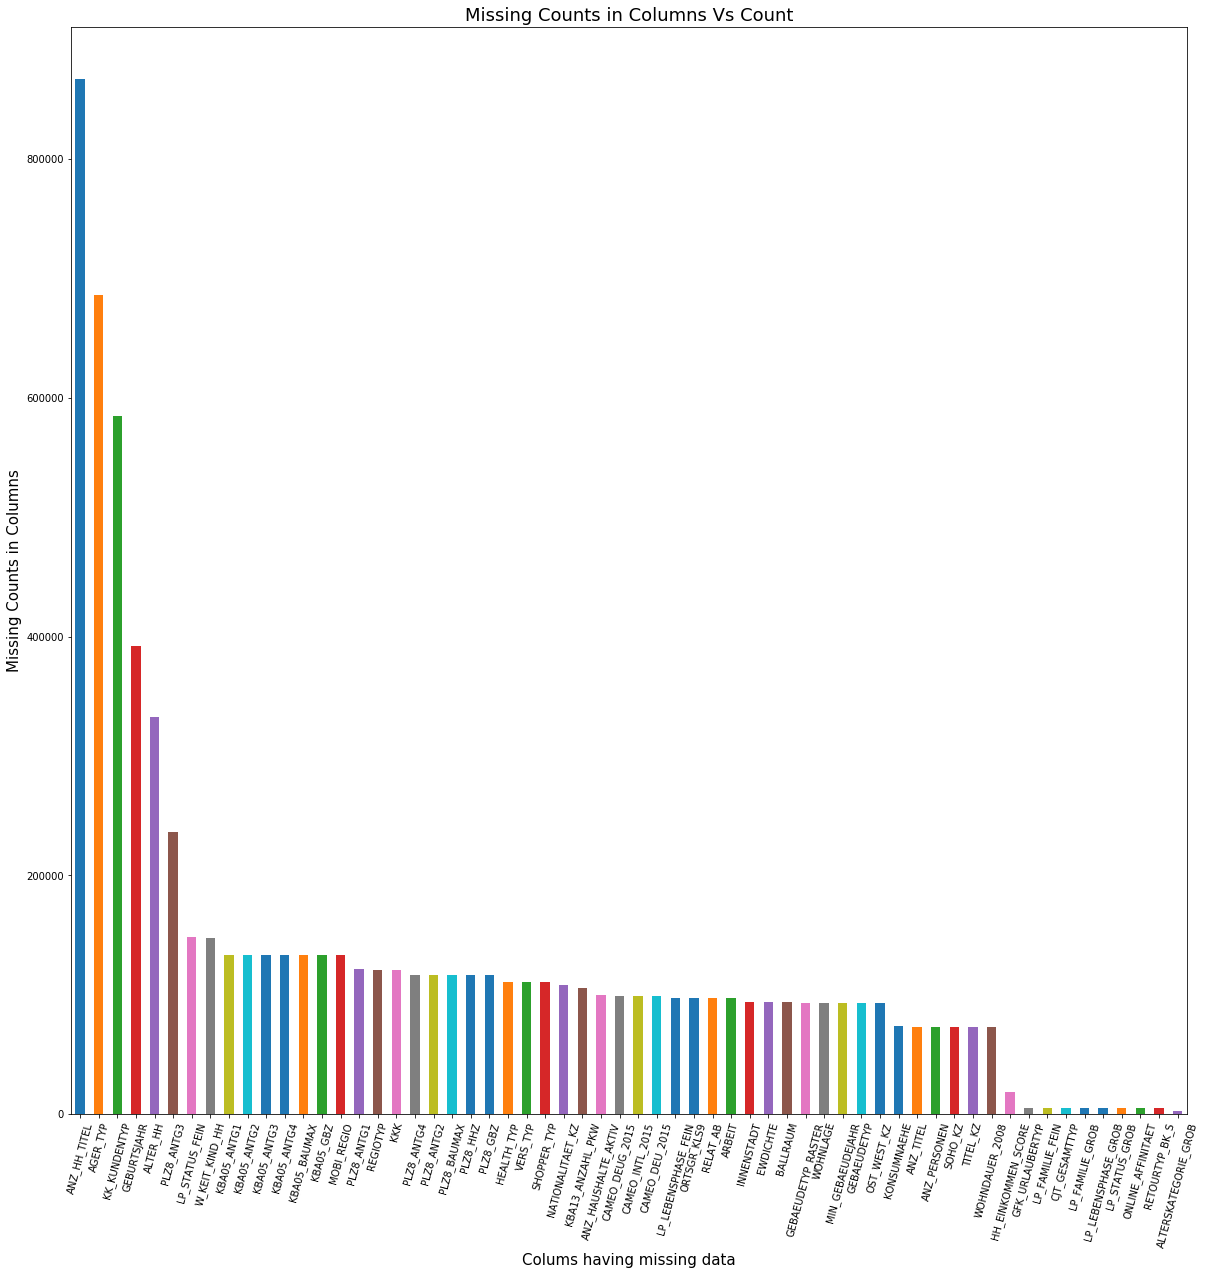

In [22]:

plt.figure(figsize=[10,10])
dfn.plot.bar(figsize=[20,20])
plt.title("Missing Counts in Columns Vs Count",size=18)
plt.xlabel("Colums having missing data",size=15)
plt.xticks(rotation=75)
plt.ylabel("Missing Counts in Columns",size=15)

Text(0,0.5,'Missing Counts in Columns')

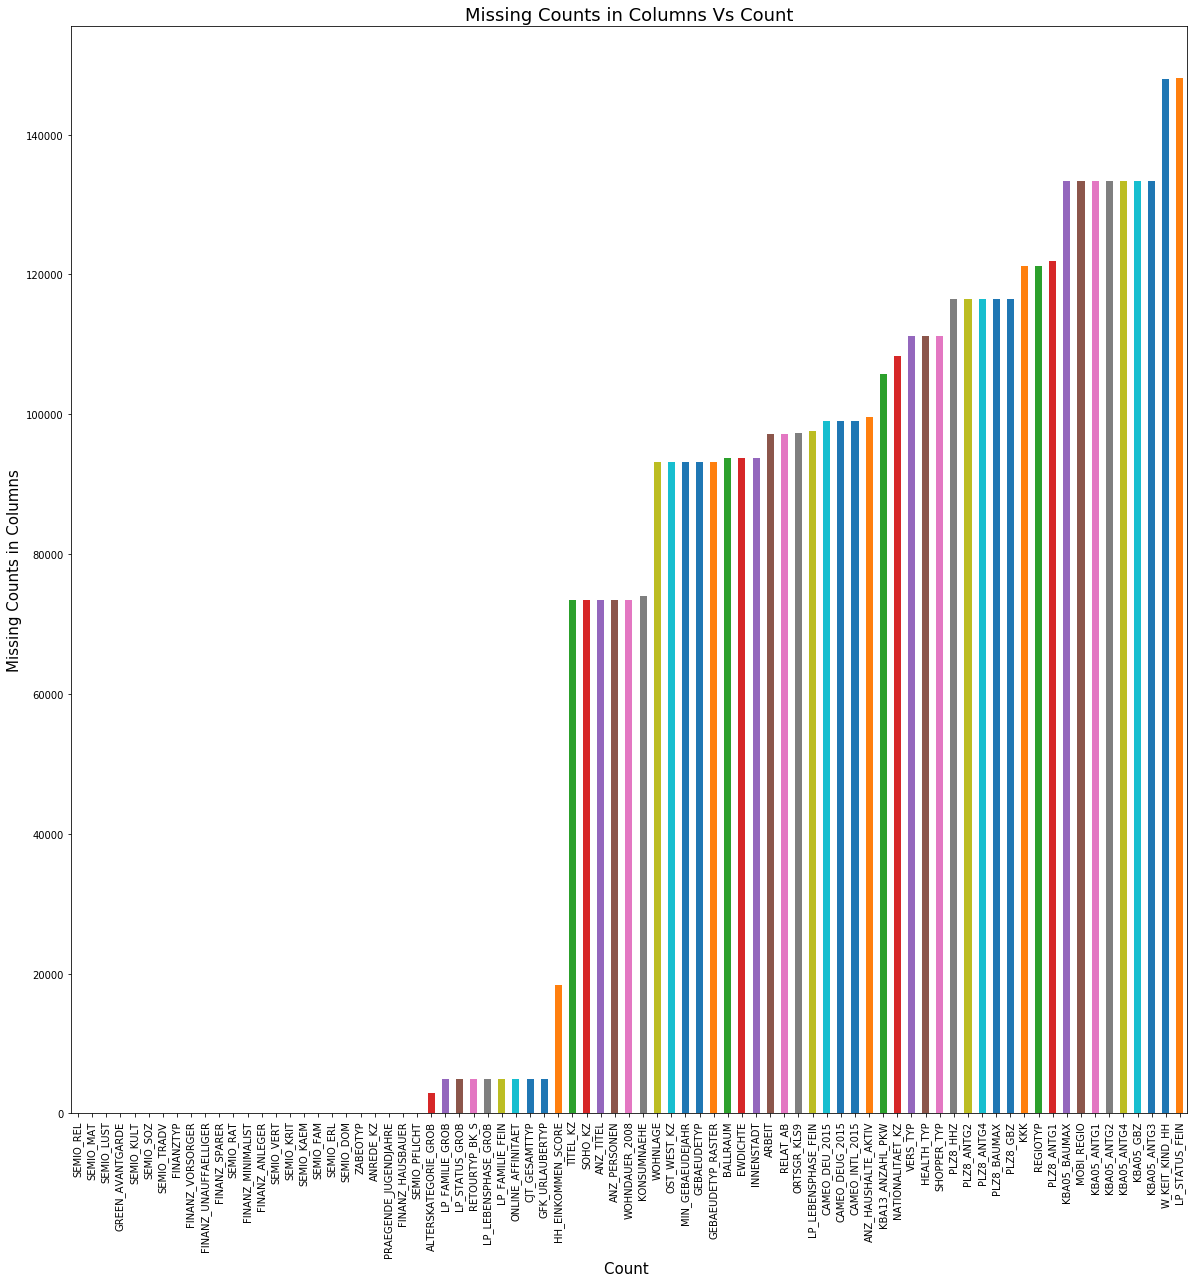

In [23]:
plt.figure(figsize=[10,10])
azdias.isnull().sum().sort_values().plot.bar(figsize=[20,20])
plt.title("Missing Counts in Columns Vs Count",size=18)
plt.xlabel("Count ",size=15)
plt.ylabel("Missing Counts in Columns",size=15)

#### Discussion 1.1.2: Assess Missing Data in Each Column

**AGER_TYP     : 685843**

**GEBURTSJAHR    : 392318**

**KK_KUNDENTYP   : 584612**

**TITEL_KZ      :  889061**

**ALTER_HH      :  310267**

**KBA05_BAUMAX  :  476524**


These columns as you see were found to be outliers for out data as they hav missing value of more than 1.3 lacs or we can also say that about more than 25 % of the data were missing in each of these colums so they must be removed.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [24]:
null_columns = azdias.columns[azdias.isnull().any()]

In [25]:
null_list = set(null_columns.tolist())
full_list=set(azdias.columns.tolist())
non_null_columns = list(full_list-null_list)
print("Followings are the colums having no missing data {}".format(non_null_columns))

Followings are the colums having no missing data ['FINANZ_VORSORGER', 'SEMIO_KRIT', 'FINANZ_ANLEGER', 'PRAEGENDE_JUGENDJAHRE', 'SEMIO_PFLICHT', 'SEMIO_DOM', 'FINANZ_MINIMALIST', 'SEMIO_ERL', 'FINANZ_HAUSBAUER', 'SEMIO_MAT', 'SEMIO_KAEM', 'ZABEOTYP', 'SEMIO_VERT', 'SEMIO_KULT', 'SEMIO_REL', 'SEMIO_TRADV', 'ANREDE_KZ', 'SEMIO_SOZ', 'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_LUST', 'SEMIO_FAM', 'SEMIO_RAT', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_SPARER']


In [26]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 79 columns):
ANZ_HAUSHALTE_AKTIV      791610 non-null float64
ANZ_PERSONEN             817722 non-null float64
ANZ_TITEL                817722 non-null float64
ARBEIT                   794005 non-null float64
BALLRAUM                 797481 non-null float64
CAMEO_DEU_2015           792242 non-null object
CAMEO_DEUG_2015          792242 non-null object
CAMEO_INTL_2015          792242 non-null object
CJT_GESAMTTYP            886367 non-null float64
EWDICHTE                 797481 non-null float64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBAEUDETYP              798073 non-null float64
GEBAEUDETYP_RASTER      

In [27]:
# How much data is missing in each row of the dataset?
print("Number of Rows having more than 1 missing data is {}".format(azdias.isnull().any(axis=1).sum()))

Number of Rows having more than 1 missing data is 349980


In [28]:
print("percentage of rows having missing data is {}".format((azdias.isnull().any(axis=1).sum())*100/azdias.shape[0]))

percentage of rows having missing data is 39.26972097829831


In [29]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
row_miss_transpose= azdias.isnull().transpose()
row_miss=row_miss_transpose.sum()
azdias_low = azdias[row_miss<26]
azdias_high = azdias[row_miss>=26];


In [30]:
azdias_high.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,EWDICHTE,...,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2.0
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2.0
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,3.0
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2.0
24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,3.0


In [31]:

print("the no. of missing rows in Low are {}".format((azdias_low.isnull().transpose().sum())))
print(" Whereas the no. of missing value in high which were removed are {}".format((azdias_high.isnull().transpose().sum())))

the no. of missing rows in Low are 1          0
2          0
3          3
4          0
5          0
6          0
7          0
8          0
9          0
10         0
12         8
13         9
15         7
16         3
18         1
19         0
20         9
21         0
22         0
23         7
25         2
26        19
27         0
28         0
29         0
31         0
32         0
33         0
34         4
36         0
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    11
891204     1
891205     0
891206     1
891207     0
891208     2
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     2
891219     0
891220     0
Length: 798032, dtype: int64
 Whereas the no. of missing value in high which were removed are 0         42
11        43
14        43
17        43
24        43
30        33


In [32]:
azdias_low.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,EWDICHTE,...,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,11.0,2.0,0.0,3.0,6.0,8A,8.0,51.0,5.0,3.0,...,3.0,1.0,0.0,2.0,3.0,9.0,4.0,5,2,1.0
2,10.0,1.0,0.0,3.0,2.0,4C,4.0,24.0,3.0,4.0,...,2.0,0.0,0.0,1.0,3.0,9.0,2.0,5,2,3.0
3,1.0,0.0,0.0,2.0,4.0,2A,2.0,12.0,2.0,2.0,...,1.0,0.0,0.0,1.0,NaN,9.0,7.0,3,2,4.0
4,3.0,4.0,0.0,4.0,2.0,6B,6.0,43.0,5.0,5.0,...,2.0,0.0,0.0,2.0,2.0,9.0,3.0,4,1,3.0
5,5.0,1.0,0.0,2.0,6.0,8C,8.0,54.0,2.0,2.0,...,0.0,0.0,0.0,2.0,6.0,9.0,7.0,4,2,1.0


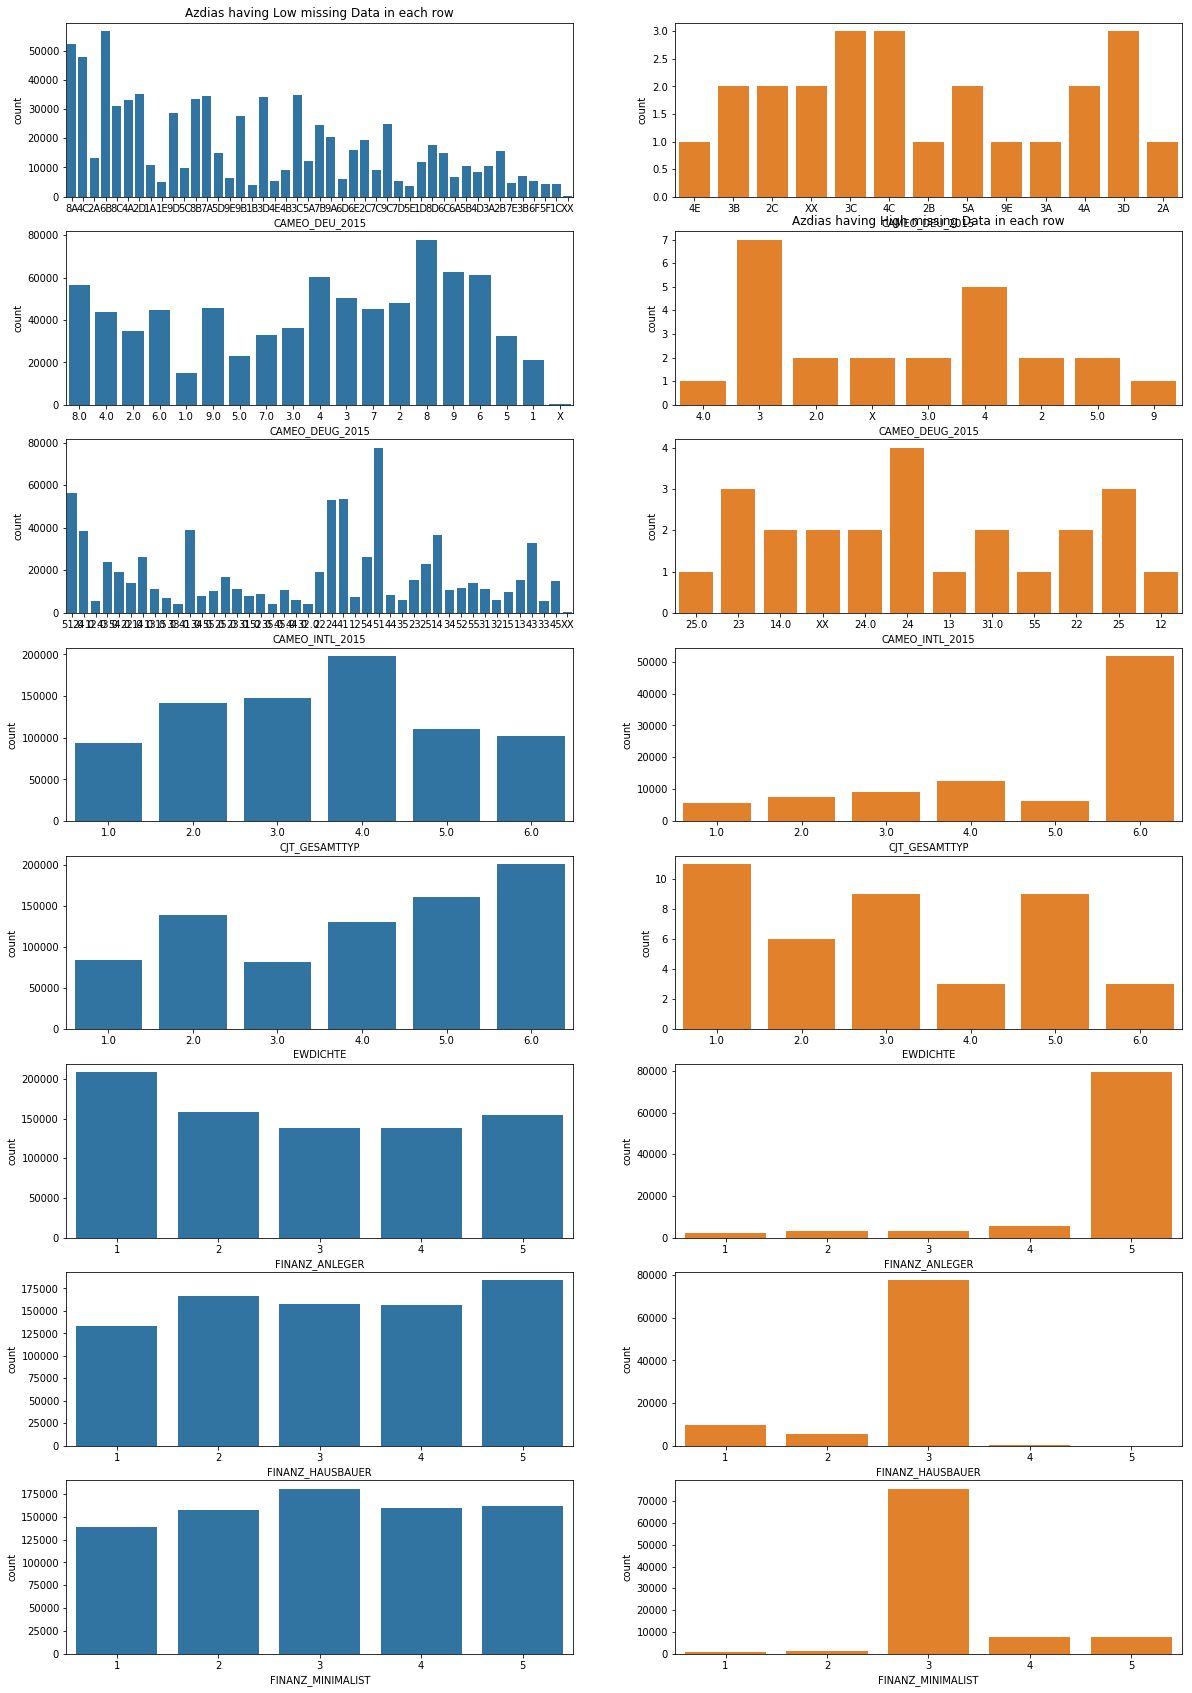

In [33]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
figure, axe = plt.subplots(nrows=8, ncols=2, figsize=(20,30))
row=0
## looking at the azdias colums the 5th to 12 th colums contains no missing data and was therefore chosen
for column in azdias.columns[5:13]:
    sns.countplot(azdias_low.loc[:, column], ax=axe[row,0],color=sns.color_palette()[0])
    
    axe[0,0].set_title('Azdias having Low missing Data in each row')
    
    sns.countplot(azdias_high.loc[:, column], ax=axe[row,1],color=sns.color_palette()[1])
    
    axe[1,1].set_title('Azdias having High missing Data in each row')
    row+=1


In [34]:
print("The percentage of missing data in azdias low missing data having missing data less than 26 is {}".format(((azdias_low.isnull().any(axis=1).sum())*100/azdias.shape[0])))

The percentage of missing data in azdias low missing data having missing data less than 26 is 28.81339196450712


#### Discussion 1.1.3: Assess Missing Data in Each Row


**missing data in rows observation**:The data with lots of missing values are qualitatively different from data with few or no missing values hence we should continue with the Encoding of the low missing azdias data as you can see we have almost 28 % of the missing data in the new data while originally it was 30 % missing data in rows.so 12 % of missing data wouldn't affect much

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [35]:
# How many features are there of each data type?
print("Following is the table showing no. of data type in azdia data")
feat_info.groupby('type').count()

Following is the table showing no. of data type in azdia data


,attribute,information_level,missing_or_unknown
type,,,
categorical,21,21,21
interval,1,1,1
mixed,7,7,7
numeric,7,7,7
ordinal,49,49,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [36]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categor=feat_info[feat_info['type']=='categorical'].attribute.values
category=[]
for cat in categor:
    if cat in azdias.columns:
        category.append(cat)
binary_one,binary_two,multi = [],[],[]
for x in category:
    if azdias[x].nunique()==1:
        binary_one.append(x)
    elif azdias[x].nunique()==2:
        binary_two.append(x)
    elif azdias[x].nunique() >2:
        multi.append(x)

In [37]:
azdias[binary_two].nunique()

ANREDE_KZ           2
GREEN_AVANTGARDE    2
SOHO_KZ             2
VERS_TYP            2
OST_WEST_KZ         2
dtype: int64

Encoding **OST_WEST_KZ**
Building location via former East / West Germany (GDR / FRG)

-  O: East (GDR) to 0
-  W: West (FRG) to 1

In [38]:
#changing the label as per mentioned above in the markdown cell
azdias_low['OST_WEST_KZ'] = azdias_low['OST_WEST_KZ'].map({'O':0,'W':1})

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [39]:
#checking whether the mapping took place correctly or not
azdias_low['OST_WEST_KZ'].head(4)

1    1
2    1
3    1
4    1
Name: OST_WEST_KZ, dtype: int64

In [40]:
azdias[multi].nunique()

CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
LP_FAMILIE_FEIN     12
LP_FAMILIE_GROB      6
LP_STATUS_FEIN       9
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          4
TITEL_KZ             6
ZABEOTYP             6
GEBAEUDETYP          7
CAMEO_DEUG_2015     19
CAMEO_DEU_2015      45
dtype: int64

In [41]:
# Removing the attribute 'CAMEO_DEU_2015' as it contain lots of variable 
azdias_low.drop('CAMEO_DEU_2015',axis=1,inplace=True)# using drop method 

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [42]:
multi.remove('CAMEO_DEU_2015')#removing the cameo_deu_2015column name from the list

In [43]:
# Re-encode categorical variable(s) to be kept in the analysis.
for each in multi:
    dummy_variable = pd.get_dummies(azdias_low[each][azdias_low[each].notnull()],prefix=each)#creating dummies for each colum im multivariable
    azdias_low = pd.concat([azdias_low,dummy_variable],axis=1)
    azdias_low.drop(each,axis=1,inplace=True)#dropping the column from our testing data i.e azdias_low


In [44]:
azdias_low.info()#gathering some information about out new data on which analysis is to be made

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798032 entries, 1 to 891220
Columns: 166 entries, ANZ_HAUSHALTE_AKTIV to CAMEO_DEUG_2015_X
dtypes: float64(116), int64(24), object(1), uint8(25)
memory usage: 883.6+ MB


#### Discussion 1.2.1: Re-Encode Categorical Features

 - CAMEO_DEU_2015 atrribute having 44 variable seems to be useless according to me as it will contribute very less in prediction so i decided to remove it.
 - Now then i have checkeck every attribute having binary value which take two value and found that attribute 'OST_WEST_KZ' needs mapping from 'O' to 0 and 'W' to 1.
 - Then one hotcoder was used to deal with the multi variable attributes using get_dummies available form the pandas libraray.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [45]:
mix = feat_info[feat_info['type']=='mixed']['attribute'].values
mixed = []
for x in mix:
    if x in azdias_low.columns:
        mixed.append(x)

In [46]:
mixed

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_BAUMAX',
 'PLZ8_BAUMAX']

In [47]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.


def avat(data):
    main = [1, 3, 5, 8, 10, 12, 14]
    avant = [2, 4, 6, 7, 9, 11, 13, 15]
    avat=[]
    for x in data['PRAEGENDE_JUGENDJAHRE']:
    
        if x in main:
            avat.append(0)
        elif x in avant:
            avat.append(1)
        else:
            avat.append(np.nan)
            
    frame = pd.DataFrame(avat)
    pd.concat([data,frame],axis=1)
    
    dicts = {1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}
    data['dekade'] = data['PRAEGENDE_JUGENDJAHRE'].map(dicts)
    
    return data


In [48]:
azdias_low = avat(azdias_low)

In [49]:
azdias_low.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798032 entries, 1 to 891220
Columns: 167 entries, ANZ_HAUSHALTE_AKTIV to dekade
dtypes: float64(117), int64(24), object(1), uint8(25)
memory usage: 909.7+ MB


In [50]:
feat_info.missing_or_unknown = feat_info.missing_or_unknown.replace('[-1,XX]', "[-1,'XX']")
feat_info.missing_or_unknown = feat_info.missing_or_unknown.replace('[XX]', "['XX']")
feat_info.missing_or_unknown = feat_info.missing_or_unknown.replace('[-1,X]', "[-1,'X']")
from ast import literal_eval
# Convert string representation to a list
feat_info.missing_or_unknown = feat_info.missing_or_unknown.apply(literal_eval)

In [51]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
def cameo(data):
    CAMEO_INTL_2015_NEW = []
    data['CAMEO_INTL_2015']=data['CAMEO_INTL_2015'].astype(float)
    for x in data['CAMEO_INTL_2015']:
        if x<=20:
            CAMEO_INTL_2015_NEW.append(1)
        elif x<=30:
            CAMEO_INTL_2015_NEW.append(2)
        elif x<=40:
            CAMEO_INTL_2015_NEW.append(3)
        elif x<=50:
            CAMEO_INTL_2015_NEW.append(4)
        elif x<=60:
            CAMEO_INTL_2015_NEW.append(5)
        else:
            CAMEO_INTL_2015_NEW.append(np.nan)
    frame2 = pd.DataFrame(CAMEO_INTL_2015_NEW)
    pd.concat([data,frame2],axis=1)
    
    return data
            
            


In [53]:
azdias_low.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798032 entries, 1 to 891220
Columns: 167 entries, ANZ_HAUSHALTE_AKTIV to dekade
dtypes: float64(117), int64(24), object(1), uint8(25)
memory usage: 909.7+ MB


#### Discussion 1.2.2: Engineer Mixed-Type Features

in the mixed type following actions were taken:
 - PRAEGENDE_JUGENDJAHRE column was investigated and two new colums were made for avantagram and mainstram after looking into the Data_dictionaty.md file.
 - also one more columns i.e 'DEKADE' was added based on the years.
 - For CAMEO_INTL_2015 the colums were mapped with 5 values based on the wealth of the person.
 - For other mixed-type features ('LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB'EBENSPHASE_FEIN', 'WOHNLAGE', 'PLZ8_BAUMAX']) were dropped on the basis that the information in these features were already included in other features in the dataset,like "ALTERSKATEGORIE_GROB","LP_FAMILIE_FEIN" and "LP_STATUS_FEIN" so on..and therfore according to me it wasn't necessary to re-engineer and keep them in the dataset.
 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [54]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

azdias_low.drop(mixed,axis=1,inplace=True)

In [55]:
azdias_low.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798032 entries, 1 to 891220
Columns: 160 entries, ANZ_HAUSHALTE_AKTIV to dekade
dtypes: float64(112), int64(23), uint8(25)
memory usage: 867.1 MB


For other mixed-type features ('LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB'EBENSPHASE_FEIN',
 'WOHNLAGE', 'PLZ8_BAUMAX']) were dropped on the basis that the information in these features were already included in other features in the dataset,like "ALTERSKATEGORIE_GROB","LP_FAMILIE_FEIN" and "LP_STATUS_FEIN" so on..and therfore according to me it wasn't necessary to re-engineer and keep them in the dataset.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [56]:
def clean_data(azdiasd):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Load in the general demographics data.
    #azdiasd = pd.read_csv('customers.csv')
    #azdiasd = azdiasd.drop('Unnamed: 0',axis=1)
# Load in the feature summary file.
    feat_infod = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=";")


    for i,j in enumerate(azdiasd.iteritems()):
            missing_unknown = feat_infod['missing_or_unknown'][i]
            column_name_miss = j[0]
            missing_unknown = missing_unknown[1:-1].split(',')
            if missing_unknown != ['']:
                replaced = []
                for k in missing_unknown:
                    if k in ['X','XX']:
                        replaced.append(k)
                    else:
                        replaced.append(int(k))
                azdiasd[column_name_miss] = azdiasd[column_name_miss].replace(replaced,np.nan)



    row_miss_transpose= azdiasd.isnull().transpose()
    row_miss=row_miss_transpose.sum()
    azdias_lowd = azdiasd[row_miss<26]
    azdias_highd = azdiasd[row_miss>=26];


# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
    categor=feat_infod[feat_infod['type']=='categorical'].attribute.values
    category=[]
    for cat in categor:
        if cat in azdiasd.columns:
            category.append(cat)
    binary_one,binary_two,multi = [],[],[]
    for x in category:
        if azdiasd[x].nunique()==1:
            binary_one.append(x)
        elif azdiasd[x].nunique()==2:
            binary_two.append(x)
        elif azdiasd[x].nunique() >2:
            multi.append(x)

#changing the label as per mentioned above in the markdown cell
    azdias_lowd['OST_WEST_KZ'] = azdias_lowd['OST_WEST_KZ'].map({'O':0,'W':1})

# Removing the attribute 'CAMEO_DEU_2015' as it contain lots of variable 
    azdias_lowd.drop('CAMEO_DEU_2015',axis=1,inplace=True)# using drop method 

    multi.remove('CAMEO_DEU_2015')#removing the cameo_deu_2015column name from the list

# Re-encode categorical variable(s) to be kept in the analysis.
    for each in multi:
        dummy_variable = pd.get_dummies(azdias_lowd[each][azdias_lowd[each].notnull()],prefix=each)#creating dummies for each colum im multivariable
        #azdias_lowd = azdias_lowd.join(dummy_variable)
        pd.concat([azdias_lowd,dummy_variable],axis=1)
        azdias_lowd=azdias_lowd.drop(each,axis=1)#dropping the column from our testing data i.e azdias_low


    mix = feat_infod[feat_infod['type']=='mixed']['attribute'].values
    mixed = []
    for x in mix:
        if x in azdias_lowd.columns:
            mixed.append(x)


# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.


    def avat(data_x):
        main = [1, 3, 5, 8, 10, 12, 14]
        avant = [2, 4, 6, 7, 9, 11, 13, 15]
        avat=[]
        for x in data_x['PRAEGENDE_JUGENDJAHRE']:
    
            if x in main:
                avat.append(0)
            elif x in avant:
                avat.append(1)
            else:
                avat.append(np.nan)
            
        frame = pd.DataFrame(avat)
        pd.concat([data_x,frame],axis=1)
    
        dicts = {1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}
        data_x['dekade'] = data_x['PRAEGENDE_JUGENDJAHRE'].map(dicts)
    
        return data_x

    azdias_lowd = avat(azdias_lowd)

    feat_infod.missing_or_unknown = feat_infod.missing_or_unknown.replace('[-1,XX]', "[-1,'XX']")
    feat_infod.missing_or_unknown = feat_infod.missing_or_unknown.replace('[XX]', "['XX']")
    feat_infod.missing_or_unknown = feat_infod.missing_or_unknown.replace('[-1,X]', "[-1,'X']")
    from ast import literal_eval
# Convert string representation to a list
    feat_infod.missing_or_unknown = feat_infod.missing_or_unknown.apply(literal_eval)
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    def cameo(data_y):
        CAMEO_INTL_2015_NEW = []
        data_y['CAMEO_INTL_2015']=data_y['CAMEO_INTL_2015'].astype(float)
        for x in data_y['CAMEO_INTL_2015']:
            if x<=20:
                CAMEO_INTL_2015_NEW.append(1)
            elif x<=30:
                CAMEO_INTL_2015_NEW.append(2)
            elif x<=40:
                CAMEO_INTL_2015_NEW.append(3)
            elif x<=50:
                CAMEO_INTL_2015_NEW.append(4)
            elif x<=60:
                CAMEO_INTL_2015_NEW.append(5)
            else:
                CAMEO_INTL_2015_NEW.append(np.nan)
        frame2 = pd.DataFrame(CAMEO_INTL_2015_NEW)
        pd.concat([data_y,frame2],axis=1)
    
        return data_y

    #azdias_lowd=cameo(azdias_lowd)


#dropping all other columns which is not to be used in analysis in futher proceedings


    azdias_lowd.drop(mixed,axis=1,inplace=True)
    mul = ['ALTER_HH', 'GEBURTSJAHR','ANZ_HH_TITEL', 'PLZ8_ANTG3']
    azdias_lowd.drop(mul,axis=1,inplace=True)
    columns = [col for col in azdias_low if col not in azdias_lowd]
    for column in columns:
        azdias_lowd[column] = 0
            
    return azdias_lowd            


    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [57]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values=np.nan, strategy='most_frequent')
azdias_low_imp = imp.fit_transform(azdias_low)
azdias_imp=pd.DataFrame(azdias_low_imp,columns=azdias_low.columns)

In [58]:
azdias_imp.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,...,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_9.0,CAMEO_DEUG_2015_X,dekade
0,11.0,2.0,0.0,3.0,6.0,3.0,5.0,5.0,1.0,5.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.0
1,10.0,1.0,0.0,3.0,2.0,4.0,2.0,5.0,1.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
2,1.0,0.0,0.0,2.0,4.0,2.0,2.0,2.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3,3.0,4.0,0.0,4.0,2.0,5.0,1.0,2.0,4.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
4,5.0,1.0,0.0,2.0,6.0,2.0,2.0,5.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0


In [59]:
azdias_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798032 entries, 0 to 798031
Columns: 160 entries, ANZ_HAUSHALTE_AKTIV to dekade
dtypes: float64(160)
memory usage: 974.2 MB


In [60]:
# Apply feature scaling to the general population demographics data.
sc = StandardScaler()
azdias_sc=sc.fit_transform(azdias_imp)
azdias_new = pd.DataFrame(azdias_sc,columns=azdias_imp.columns)
azdias_new.head()


,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,...,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_9.0,CAMEO_DEUG_2015_X,dekade
0,0.173095,0.234445,-0.060409,-0.171848,0.845262,-0.547180,1.465955,1.339291,-1.494584,1.537917,...,-0.288333,-0.243363,-0.244516,-0.207402,-0.329187,3.625602,-0.291695,-0.246175,-0.021566,1.098082
1,0.109092,-0.630199,-0.060409,-0.171848,-0.986670,0.034464,-0.571001,1.339291,-1.494584,0.864559,...,-0.288333,-0.243363,-0.244516,-0.207402,-0.329187,-0.275816,-0.291695,-0.246175,-0.021566,1.098082
2,-0.466936,-1.494843,-0.060409,-1.170287,-0.070704,-1.128825,-0.571001,-0.791257,0.683159,-0.482157,...,-0.288333,-0.243363,-0.244516,-0.207402,-0.329187,-0.275816,-0.291695,-0.246175,-0.021566,-0.267766
3,-0.338930,1.963732,-0.060409,0.826590,-0.986670,0.616109,-1.249986,-0.791257,0.683159,0.191201,...,-0.288333,4.109096,-0.244516,-0.207402,-0.329187,-0.275816,-0.291695,-0.246175,-0.021566,-0.267766
4,-0.210924,-0.630199,-0.060409,-1.170287,0.845262,-1.128825,-0.571001,1.339291,-0.042755,-1.155516,...,-0.288333,-0.243363,-0.244516,-0.207402,-0.329187,3.625602,-0.291695,-0.246175,-0.021566,-1.633614


In [61]:
azdias_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798032 entries, 0 to 798031
Columns: 160 entries, ANZ_HAUSHALTE_AKTIV to dekade
dtypes: float64(160)
memory usage: 974.2 MB


### Discussion 2.1: Apply Feature Scaling

 - Most Frequet Imputer is applied in the dataset as see we have to predict things and replaacing the missing values with the most frequent ones is the right way rather than the mean strategy as mean would give us the no. which does not occur frquent and hence would affects our results.
 - Secondly the standand scaling were used.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

### Helper functions are used 

In [62]:
# Apply PCA to the data.

def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.
    
    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform
           
    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    
    pca = PCA(n_components)
    data_pca = pca.fit_transform(data)
    return pca, data_pca

In [63]:
def pca_results(full_dataset, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)

In [64]:
#using random number of components to check the variance then applying suitable range in next cell
#pca,data_pca = do_pca(33,azdias_new)
#var = pca_results(azdias_new,pca)
#var['Explained Variance'].sum()

In [65]:
# Investigate the variance accounted for by each principal component.
for n_com in range(41,azdias_new.shape[1]):
    pca,data_pca = do_pca(n_com,azdias_new)
    var = pca_results(azdias_new,pca)
    if var['Explained Variance'].sum() >0.6:
        break
num_comps = var.shape[0]
print("Using {} components, we can explain {}% of the variability in the original data.".format(var.shape[0],var['Explained Variance'].sum()))


Using 41 components, we can explain 0.6046999999999999% of the variability in the original data.


In [66]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_azdias,azdias_pca=do_pca(41,azdias_new)
variance_tab=pca_results(azdias_new,pca)

In [67]:
variance_tab.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41 entries, Dimension 1 to Dimension 41
Columns: 161 entries, Explained Variance to dekade
dtypes: float64(161)
memory usage: 51.9+ KB


In [68]:
variance_tab.head()

,Explained Variance,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,...,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_9.0,CAMEO_DEUG_2015_X,dekade
Dimension 1,0.0815,0.1137,-0.0797,-0.0076,0.1081,-0.0971,0.1503,0.1032,0.1397,-0.2237,...,-0.0003,-0.0002,0.0225,0.0185,0.0607,0.0508,0.0796,0.0669,-0.0024,0.1329
Dimension 2,0.0670,0.0789,-0.0934,0.0054,0.0788,-0.0690,0.1063,-0.1833,0.1290,0.0297,...,0.0090,0.0082,0.0142,0.0119,0.0426,0.0358,0.0357,0.0301,-0.0030,-0.2050
Dimension 3,0.0423,0.0277,-0.0112,0.0153,0.0348,-0.0444,0.0566,-0.1525,-0.0493,0.1227,...,-0.0032,-0.0010,0.0012,0.0007,0.0120,0.0095,0.0190,0.0161,-0.0004,-0.0610
Dimension 4,0.0285,0.0333,0.2543,0.0617,0.0915,-0.1804,0.2186,-0.0750,-0.0450,0.0311,...,-0.0199,-0.0164,-0.0083,-0.0061,0.0072,0.0065,0.0135,0.0115,0.0000,0.0093
Dimension 5,0.0220,-0.0363,-0.2157,0.1308,-0.0466,-0.1046,0.1080,-0.0691,-0.0299,0.0013,...,-0.0176,-0.0164,0.0007,-0.0011,-0.0400,-0.0321,-0.0379,-0.0318,0.0084,0.0269


### Discussion 2.2: Perform Dimensionality Reduction

Using 41 components, we can explain 60.37% of the variability in the original data

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [69]:
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def map_weight(dimensions,weights):
    print("The top {} intresting features for {} principal components are".format(weights,dimensions))
    print(variance_tab.iloc[(dimensions)-1].sort_values(ascending=False)[:weights])
    
    print("*"*20)
    print("The least {} intresting features for {} principal components are".format(weights,dimensions))
    print(variance_tab.iloc[(dimensions)-1].sort_values(ascending=True)[:weights])
    

In [70]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_weight(1,10)

The top 10 intresting features for 1 principal components are
LP_STATUS_GROB_1.0    0.2029
HH_EINKOMMEN_SCORE    0.1849
FINANZ_SPARER         0.1713
PLZ8_ANTG4            0.1686
ORTSGR_KLS9           0.1524
FINANZTYP_1           0.1514
EWDICHTE              0.1503
LP_STATUS_FEIN_2.0    0.1446
FINANZ_HAUSBAUER      0.1397
SEMIO_PFLICHT         0.1337
Name: Dimension 1, dtype: float64
********************
The least 10 intresting features for 1 principal components are
FINANZ_MINIMALIST      -0.2237
MOBI_REGIO             -0.1866
KBA05_ANTG1            -0.1790
KBA05_GBZ              -0.1785
PLZ8_ANTG1             -0.1727
ALTERSKATEGORIE_GROB   -0.1404
FINANZ_VORSORGER       -0.1367
KONSUMNAEHE            -0.1323
PLZ8_GBZ               -0.1275
INNENSTADT             -0.1264
Name: Dimension 1, dtype: float64


In [71]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weight(2,10)


The top 10 intresting features for 2 principal components are
ALTERSKATEGORIE_GROB    0.2064
ZABEOTYP_3              0.1962
FINANZ_VORSORGER        0.1925
SEMIO_ERL               0.1692
RETOURTYP_BK_S          0.1502
SEMIO_LUST              0.1468
W_KEIT_KIND_HH          0.1361
LP_STATUS_FEIN_1.0      0.1312
FINANZ_HAUSBAUER        0.1290
PLZ8_ANTG4              0.1086
Name: Dimension 2, dtype: float64
********************
The least 10 intresting features for 2 principal components are
dekade                  -0.2050
FINANZ_UNAUFFAELLIGER   -0.1965
SEMIO_REL               -0.1915
FINANZ_SPARER           -0.1908
SEMIO_TRADV             -0.1890
FINANZ_ANLEGER          -0.1833
SEMIO_PFLICHT           -0.1785
ONLINE_AFFINITAET       -0.1771
SEMIO_KULT              -0.1554
SEMIO_RAT               -0.1435
Name: Dimension 2, dtype: float64


In [72]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weight(3,10)


The top 10 intresting features for 3 principal components are
SEMIO_VERT           0.3219
SEMIO_FAM            0.2642
SEMIO_SOZ            0.2588
SEMIO_KULT           0.2550
FINANZTYP_5          0.1335
SHOPPER_TYP_0.0      0.1236
FINANZ_MINIMALIST    0.1227
SEMIO_REL            0.1135
ZABEOTYP_1           0.1054
SEMIO_MAT            0.0894
Name: Dimension 3, dtype: float64
********************
The least 10 intresting features for 3 principal components are
ANREDE_KZ            -0.3502
SEMIO_KAEM           -0.3203
SEMIO_DOM            -0.2918
SEMIO_KRIT           -0.2679
SEMIO_ERL            -0.2075
SEMIO_RAT            -0.1599
FINANZ_ANLEGER       -0.1525
FINANZTYP_1          -0.1001
SHOPPER_TYP_2.0      -0.0927
LP_STATUS_FEIN_2.0   -0.0774
Name: Dimension 3, dtype: float64


### Discussion 2.3: Interpret Principal Components

After analysing the top 10 positive and negative features followings were the points i got to know for each principal components:

 - Principal Component 1:
 
     - **Positive**
     - low-income earners (maps to 1-2 in fine scale)
     - Number of 6-10 family houses in the PLZ8 region
     
     - **Neagtive:**
     - MINIMALIST: low financial interest
     - movement pattern less intrested
 - Principal component 2:
    - **positive:** 
    - Estimated age based on given name analysis
    - VORSORGER: be prepared

    - **Negative:**
    - money saver and old ages
 - Principal component 3:

     - **Positive:**
     - dramful family and social minded people are found to be interesting features.
     - critical,dominant minded people are the negaative features alogh with people having combative attitude.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [73]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans,MiniBatchKMeans


In [74]:
k_means_scores=[]
for k in range(7,30,1):
    
    # run k-means clustering on the data and...
    k_means = MiniBatchKMeans(k)
    
    # compute the average within-cluster distances.
    
    k_means.fit(data_pca)
    
    #compute the average within-cluster distances.
    print(k,k_means.score(data_pca))
    k_means_scores.append(k_means.score(data_pca))
    

7 -57998522.3723
8 -58249465.0834
9 -55936052.5205
10 -56025724.0885
11 -52990559.3837
12 -54087747.8024
13 -51296636.6044
14 -53109401.8815
15 -50086734.7675
16 -52620513.5732
17 -51522428.4757
18 -51589365.6112
19 -46971690.6023
20 -49520213.5672
21 -50496950.2595
22 -46971080.7838
23 -46406467.8986
24 -47593145.0353
25 -45858025.3085
26 -45190484.203
27 -46933174.5535
28 -46612815.367
29 -44665414.405


Text(0,0.5,'Kmean Score')

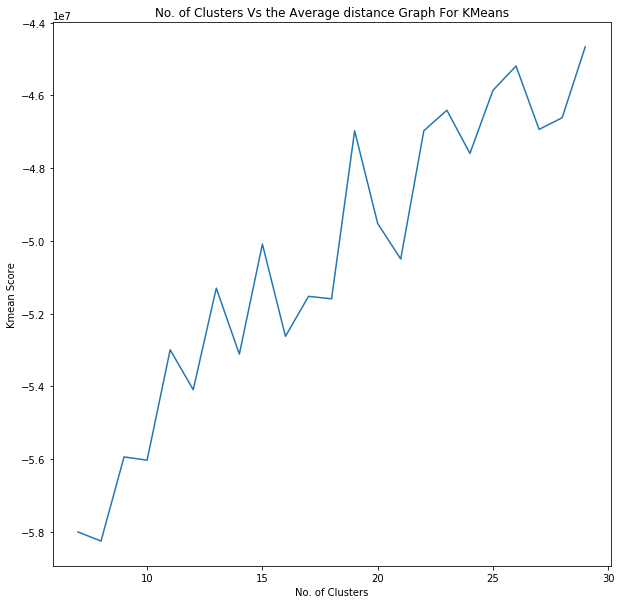

In [75]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.figure(figsize=[10,10])
plt.plot(list(range(7,30,1)),k_means_scores);
plt.title("No. of Clusters Vs the Average distance Graph For KMeans")
plt.xlabel('No. of Clusters')
plt.ylabel("Kmean Score")

In [76]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kme = MiniBatchKMeans(18)
population_cluster=kme.fit_predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

**NOTE: Since the iteration took so long so after performing several iteration i found that the SSE score from cluster 17 to 19 changed very little as compared to other cluster so Into 18 clusters i have decided to segment the population after seeing the elbow graph formed due to plot between the average distance and the number of clusters**.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [77]:
# Load in the customer demographics data.
customers_data =pd.read_csv('customers.csv') #pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [79]:
customers_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 85 columns):
AGER_TYP                 191652 non-null int64
ALTER_HH                 145056 non-null float64
ANZ_HAUSHALTE_AKTIV      141725 non-null float64
ANZ_HH_TITEL             139542 non-null float64
ANZ_PERSONEN             145056 non-null float64
ANZ_TITEL                145056 non-null float64
ARBEIT                   141176 non-null float64
BALLRAUM                 141693 non-null float64
CAMEO_DEU_2015           141224 non-null object
CAMEO_DEUG_2015          141224 non-null object
CAMEO_INTL_2015          141224 non-null object
CJT_GESAMTTYP            188439 non-null float64
EWDICHTE                 141693 non-null float64
FINANZ_ANLEGER           191652 non-null int64
FINANZ_HAUSBAUER         191652 non-null int64
FINANZ_MINIMALIST        191652 non-null int64
FINANZ_SPARER            191652 non-null int64
FINANZ_UNAUFFAELLIGER    191652 non-null int64
FINANZ_VORSORGER      

In [80]:
customers_data.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,...,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2,10.0,1.0,0.0,2.0,0.0,1.0,3.0,1A,1.0,...,3,0.0,0.0,1,6.0,9.0,7.0,3,1,4
1,-1,11.0,NaN,NaN,3.0,0.0,NaN,NaN,NaN,NaN,...,3,0.0,0.0,1,0.0,9.0,NaN,3,1,4
2,-1,6.0,1.0,0.0,1.0,0.0,3.0,7.0,5D,5.0,...,1,0.0,0.0,2,6.0,9.0,2.0,3,2,4
3,1,8.0,0.0,NaN,0.0,0.0,1.0,7.0,4C,4.0,...,0,0.0,0.0,1,NaN,9.0,7.0,1,1,4
4,-1,20.0,7.0,0.0,4.0,0.0,3.0,3.0,7B,7.0,...,1,0.0,0.0,2,2.0,9.0,3.0,1,1,3


In [78]:
customers_data = customers_data.drop('Unnamed: 0',axis=1)

In [81]:
missing_row_data_cust = customers_data.isnull().sum(axis=1)
customer_rows_deleted = customers_data[missing_row_data_cust >= 26]
customer_rows_deleted.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,...,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,-1,11.0,NaN,NaN,3.0,0.0,NaN,NaN,NaN,NaN,...,3,0.0,0.0,1,0.0,9.0,NaN,3,1,4
10,-1,14.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,...,3,0.0,0.0,1,0.0,3.0,NaN,3,2,3
36,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,NaN,NaN,-1,NaN,NaN,NaN,3,2,1
37,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,NaN,NaN,-1,NaN,NaN,NaN,3,2,3
38,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,NaN,NaN,-1,NaN,NaN,NaN,3,2,2


In [82]:
# Apply preprocessing, feature transformation, and clustering from the general
customer_data = clean_data(customers_data)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [83]:
set(customer_data.columns.tolist())-set(azdias_low.columns.tolist())

set()

In [84]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141688 entries, 0 to 191651
Columns: 160 entries, ANZ_HAUSHALTE_AKTIV to CAMEO_DEUG_2015_X
dtypes: float64(36), int64(124)
memory usage: 179.0 MB


In [85]:
cust_imp_data = pd.DataFrame(imp.transform(customer_data), columns = customer_data.columns)# Cheching if the nun values are treated well or not
cust_imp_data = pd.DataFrame(sc.transform(cust_imp_data), columns = cust_imp_data.columns)#standard Scaling done on cusrtomer

# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

In [ ]:
dsa

In [86]:
cust_imp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141688 entries, 0 to 141687
Columns: 160 entries, ANZ_HAUSHALTE_AKTIV to CAMEO_DEUG_2015_X
dtypes: float64(160)
memory usage: 173.0 MB


In [87]:

cust_pca = pca_azdias.transform(cust_imp_data)##ising the pca used in population to transform the customer dataset


In [88]:
custom_cluster=kme.predict(cust_pca)

In [89]:
custom_cluster

array([15, 17, 13, ..., 15, 17, 13], dtype=int32)

In [90]:
population_cluster

array([ 0, 10, 13, ..., 10,  8,  1], dtype=int32)

In [91]:
comb_data1 = pd.DataFrame(custom_cluster)
comb_data2 = pd.DataFrame(population_cluster)
comb_data1.columns = ['cust_cluster']
comb_data2.columns = ['pop_cluster']

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,0,'Cluster')

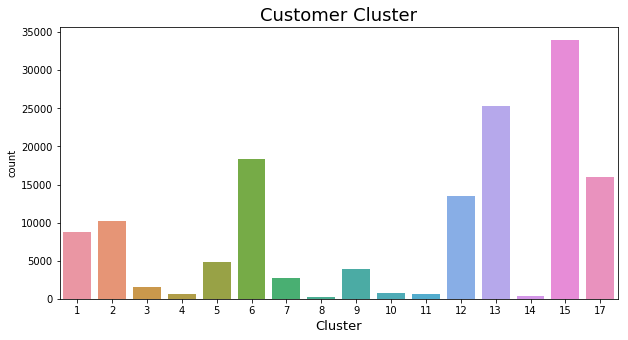

In [92]:
plt.figure(figsize=[10,5])
sns.countplot(data=comb_data1,x='cust_cluster')
plt.title("Customer Cluster",size=18)
plt.xlabel("Cluster",size=13)

Text(0.5,0,'Cluster')

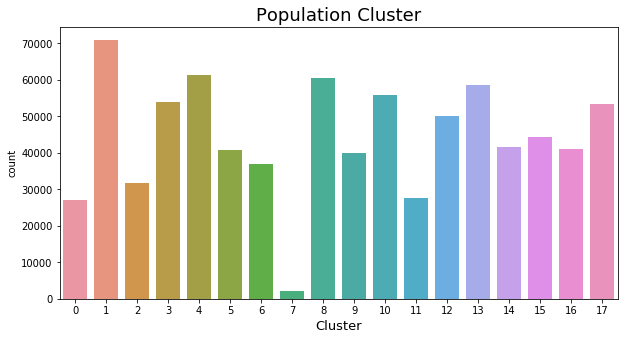

In [93]:
plt.figure(figsize=[10,5])
sns.countplot(data=comb_data2,x='pop_cluster')
plt.title("Population Cluster",size=18)
plt.xlabel("Cluster",size=13)

In [94]:
comb_data = pd.concat([comb_data1,comb_data2],axis=1)
comb_data.columns=['customer_cluster','population_cluster']

In [95]:
customer = comb_data.customer_cluster.value_counts().sort_index()
population = comb_data.population_cluster.value_counts().sort_index()

In [96]:
customer

1.0      8763
2.0     10264
3.0      1501
4.0       622
5.0      4868
6.0     18337
7.0      2670
8.0       220
9.0      3929
10.0      757
11.0      681
12.0    13497
13.0    25248
14.0      379
15.0    33973
17.0    15979
Name: customer_cluster, dtype: int64

In [97]:
population

0     27032
1     70966
2     31774
3     54066
4     61228
5     40761
6     37006
7      2166
8     60432
9     40033
10    56002
11    27498
12    50145
13    58493
14    41732
15    44381
16    40986
17    53331
Name: population_cluster, dtype: int64

In [98]:
population_miss_data,customer_miss_data=azdias_high.shape[0],float(customer_rows_deleted.shape[0])

In [99]:
customer_miss_data

49943.0

In [100]:
comb_data = pd.concat([population,customer],axis=1).reset_index()
comb_data.columns=['cluster','population','customer']





comb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 3 columns):
cluster       18 non-null int64
population    18 non-null int64
customer      16 non-null float64
dtypes: float64(1), int64(2)
memory usage: 512.0 bytes


In [101]:
add_data=pd.DataFrame([[-1,population_miss_data,customer_miss_data,]],columns=comb_data.columns)

add_data

,cluster,population,customer
0,-1,93189,49943.0


In [102]:
comb_dat = pd.concat([add_data,comb_data])

In [103]:
comb_dat['cust_perc'] = comb_dat['customer']*100/comb_dat['customer'].sum()
comb_dat['popu_perc'] = comb_dat['population']*100/comb_dat['population'].sum()
comb_dat.index = list(range(-1,18,1))

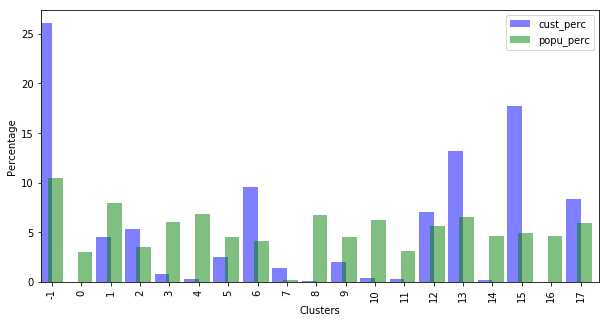

In [104]:
plt.figure(figsize=[10,5])
comb_dat['cust_perc'].plot(kind='bar',color='b',alpha=0.5,width=0.5,position=1)
comb_dat['popu_perc'].plot(kind='bar',color='g',alpha=0.5,width=0.5,position=0.25)
plt.xlabel("Clusters")
plt.ylabel("Percentage")
plt.legend()

In [105]:
cluster_name=pd.DataFrame(sc.inverse_transform(pca_azdias.inverse_transform(kme.cluster_centers_)),columns=azdias_new.columns)

In [106]:
cluster_name

,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,...,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_9.0,CAMEO_DEUG_2015_X,dekade
0,6.734261,1.488926,0.000403,3.093437,4.199729,3.822561,3.797073,2.954865,2.448356,3.526654,...,0.081873,0.038257,0.024264,0.039661,0.098102,0.048306,0.067273,0.064510,-0.001148,5.358821
1,17.518697,1.301434,-0.000753,3.569272,3.203536,5.093473,1.706177,3.495278,3.092933,2.125272,...,0.067878,0.062396,0.052688,0.057577,0.200741,0.142690,0.201788,0.125482,0.000393,3.684607
2,1.531644,1.913201,0.000898,3.003308,4.224977,3.906602,1.652930,2.568440,4.483679,1.142117,...,0.069225,0.045323,0.025330,0.017582,0.019619,0.015649,0.004436,0.005783,0.000760,3.009492
3,2.288168,2.358899,0.001578,2.715776,5.056208,2.779190,4.068651,2.175749,2.969339,4.047736,...,0.069515,0.046034,0.039385,0.037260,0.056817,0.025432,0.024530,-0.011666,0.002673,5.779876
4,16.551423,1.695005,0.001161,3.814558,3.017350,5.407029,4.243587,4.351355,1.078595,4.390368,...,0.066865,0.050961,0.099183,0.044916,0.187843,0.121683,0.180471,0.147057,-0.000042,5.678616
5,28.886091,1.418591,0.000868,3.674687,2.553687,5.539439,2.240757,4.389672,2.288742,2.078660,...,0.048535,0.021212,0.065109,0.067713,0.193270,0.130623,0.232517,0.149442,0.001550,3.621840
6,9.376452,1.381864,0.001616,3.641611,2.709344,5.300593,1.196900,3.557539,3.574306,1.719678,...,0.099514,0.083121,0.112908,0.064285,0.094581,0.072320,0.026905,0.053152,0.000098,3.521040
7,10.581184,1.542209,1.097890,3.239352,3.891365,4.433136,2.024952,3.335527,3.547804,1.986137,...,0.027161,0.037004,0.024241,0.071551,0.049141,-0.018472,0.145027,0.035108,-0.003118,3.635510
8,15.990623,1.348360,0.000214,3.690979,3.301215,4.988555,3.735521,3.742163,1.714884,4.547554,...,0.085027,0.048772,0.067692,0.047950,0.153058,0.132659,0.187258,0.149927,-0.001314,5.834065
9,6.537140,1.310119,0.001166,2.544451,5.929982,2.041010,3.223289,3.732552,2.823154,2.315936,...,0.101526,0.088616,0.071304,0.029904,0.064928,0.070495,0.046665,0.033485,0.000149,3.999062


In [107]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

#Ans 6,131517 are the cluster which are overpresented 

In [108]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

#ans 4,5, 6,9 , 15,16 are the clusters which are underrepresented

### Discussion 3.3: Compare Customer Data to Demographics Data

The population segment contains more missing data than the customer segment so results might get affected

segments of the population that are relatively popular with the mail-order company are of type:
 - 46 - 60 years old
 - having low financial interest
 - money saver
 - sanitary affine
 - person having comabtive attitude
 
Segment relatively unpopular with the company:
 - Relativly young age
 - investors types
 - inconspicious
 - high financial interest 

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

#### MAIL OUT TRAIN SECTION

In [109]:
# Load train dataset
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [111]:
mailout_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 367 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 120.3+ MB


In [114]:
non_feature_col = list(set(azdias_attr) - set(feat_info_attr))

In [115]:
mailout_train.drop(non_feature_col,axis=1,inplace=True)

In [116]:
mailout_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Data columns (total 86 columns):
AGER_TYP                 42962 non-null int64
ALTER_HH                 35993 non-null float64
ANZ_HAUSHALTE_AKTIV      35185 non-null float64
ANZ_HH_TITEL             34716 non-null float64
ANZ_PERSONEN             35993 non-null float64
ANZ_TITEL                35993 non-null float64
ARBEIT                   35011 non-null float64
BALLRAUM                 35163 non-null float64
CAMEO_DEU_2015           35074 non-null object
CAMEO_DEUG_2015          35074 non-null object
CAMEO_INTL_2015          35074 non-null object
CJT_GESAMTTYP            42357 non-null float64
EWDICHTE                 35163 non-null float64
FINANZ_ANLEGER           42962 non-null int64
FINANZ_HAUSBAUER         42962 non-null int64
FINANZ_MINIMALIST        42962 non-null int64
FINANZ_SPARER            42962 non-null int64
FINANZ_UNAUFFAELLIGER    42962 non-null int64
FINANZ_VORSORGER         42962 non-null in

In [117]:
# Print number of individuals whom responded to the mailout campaign
mailout_train['RESPONSE'].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [173]:
train_feat = mailout_train.drop(['RESPONSE'], axis=1)
train_response = mailout_train['RESPONSE']

In [174]:
train_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Data columns (total 85 columns):
AGER_TYP                 42962 non-null int64
ALTER_HH                 35993 non-null float64
ANZ_HAUSHALTE_AKTIV      35185 non-null float64
ANZ_HH_TITEL             34716 non-null float64
ANZ_PERSONEN             35993 non-null float64
ANZ_TITEL                35993 non-null float64
ARBEIT                   35011 non-null float64
BALLRAUM                 35163 non-null float64
CAMEO_DEU_2015           35074 non-null object
CAMEO_DEUG_2015          35074 non-null object
CAMEO_INTL_2015          35074 non-null object
CJT_GESAMTTYP            42357 non-null float64
EWDICHTE                 35163 non-null float64
FINANZ_ANLEGER           42962 non-null int64
FINANZ_HAUSBAUER         42962 non-null int64
FINANZ_MINIMALIST        42962 non-null int64
FINANZ_SPARER            42962 non-null int64
FINANZ_UNAUFFAELLIGER    42962 non-null int64
FINANZ_VORSORGER         42962 non-null in

In [151]:
for idx in feat_info.index:
    column = idx
    if column in train_feat.columns:
        train_feat[column] = train_feat[column].replace(feat_info.loc[column]['nan_vals'], np.nan)

In [152]:
train_features_cleaned =clean_data(train_feat)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [153]:
train_features_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35182 entries, 0 to 42961
Columns: 160 entries, ANZ_HAUSHALTE_AKTIV to CAMEO_DEUG_2015_X
dtypes: float64(36), int64(124)
memory usage: 44.5 MB


In [182]:
train_response=train_response.iloc[train_features_cleaned.index]

In [156]:
train_features_cleaned

,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,...,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_9.0,CAMEO_DEUG_2015_X
0,15.0,1.0,0.0,3.0,5.0,5.0,2,5,3,1,...,0,0,0,0,0,0,0,0,0,0
1,1.0,2.0,0.0,2.0,5.0,1.0,2,3,5,1,...,0,0,0,0,0,0,0,0,0,0
2,NaN,0.0,0.0,4.0,1.0,6.0,1,2,5,1,...,0,0,0,0,0,0,0,0,0,0
3,4.0,2.0,0.0,4.0,2.0,6.0,1,5,4,1,...,0,0,0,0,0,0,0,0,0,0
4,53.0,1.0,0.0,3.0,4.0,5.0,1,5,3,1,...,0,0,0,0,0,0,0,0,0,0
5,17.0,1.0,0.0,4.0,1.0,6.0,1,5,2,1,...,0,0,0,0,0,0,0,0,0,0
6,2.0,1.0,0.0,3.0,6.0,2.0,2,3,4,1,...,0,0,0,0,0,0,0,0,0,0
7,1.0,2.0,0.0,1.0,7.0,1.0,2,3,5,1,...,0,0,0,0,0,0,0,0,0,0
11,2.0,2.0,0.0,2.0,7.0,1.0,3,3,5,1,...,0,0,0,0,0,0,0,0,0,0
12,1.0,3.0,0.0,3.0,6.0,3.0,2,2,5,1,...,0,0,0,0,0,0,0,0,0,0


In [178]:
train_feat_sc = pd.DataFrame(imp.transform(train_features_cleaned), columns = train_features_cleaned.columns)# Cheching if the nun values are treated well or not
train_feat_sc = pd.DataFrame(sc.transform(train_feat_sc), columns = train_features_cleaned.columns)

In [183]:
train_feat_sc

,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,...,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_9.0,CAMEO_DEUG_2015_X
0,0.546589,-0.749098,-0.091643,-0.048262,0.338093,0.698033,0.133575,1.221819,-0.764638,-0.508898,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.377748,-0.013938,-0.091643,-1.013560,0.338093,-1.606494,0.133575,-0.206550,0.989617,-0.508898,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.377748,-1.484258,-0.091643,0.917035,-1.484234,1.274164,-0.762919,-0.920734,0.989617,-0.508898,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.179675,-0.013938,-0.091643,0.917035,-1.028652,1.274164,-0.762919,1.221819,0.112489,-0.508898,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.055504,-0.749098,-0.091643,-0.048262,-0.117489,0.698033,-0.762919,1.221819,-0.764638,-0.508898,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.678637,-0.749098,-0.091643,0.917035,-1.484234,1.274164,-0.762919,1.221819,-1.641766,-0.508898,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,-0.311724,-0.749098,-0.091643,-0.048262,0.793674,-1.030362,0.133575,-0.206550,0.112489,-0.508898,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-0.377748,-0.013938,-0.091643,-1.978857,1.249256,-1.606494,0.133575,-0.206550,0.989617,-0.508898,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,-0.311724,-0.013938,-0.091643,-1.013560,1.249256,-1.606494,1.030069,-0.206550,0.989617,-0.508898,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,-0.377748,0.721223,-0.091643,-0.048262,0.793674,-0.454231,0.133575,-0.920734,0.989617,-0.508898,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [184]:
train_feat_sc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35182 entries, 0 to 35181
Columns: 160 entries, ANZ_HAUSHALTE_AKTIV to CAMEO_DEUG_2015_X
dtypes: float64(160)
memory usage: 42.9 MB


**Classifier Selection**

In [195]:
#import library for the supervised learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold
#from xgboost.sklearn import XGBClassifier
from sklearn.metrics import roc_auc_score
import pickle
import time
import pprint
import random

In [199]:
def classifier(clf, param_grid, X=train_feat_sc, y=train_response):
    """
    Fits a classifier to its training data using GridSearchCV and calculates ROC AUC score
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    
    # cv uses StratifiedKFold
    # scoring roc_auc available as parameter
    
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc',cv=5, verbose=0)
    print("Training {} and below are the outputs :".format(clf.__class__.__name__))
    grid_search.fit(X, y)
    


    
    print("Best score : {}".format(round(grid_search.best_score_,2)))
    print("best eastimator: {}".format(grid_search.best_estimator_))
    print("-"*35)
    
    return grid_search.best_score_, grid_search.best_estimator_

In [194]:
rfc = RandomForestClassifier(random_state=42) # RandomForestClassifier
ada_boost = AdaBoostClassifier(random_state=42) # AdaBoostClassifier
grad_boost = GradientBoostingClassifier(random_state=42) # GradientBoostingClassifier


In [200]:
for clf in [rfc, ada_boost, grad_boost]:
    best_score, best_estimator = classifier(clf, {})

Training RandomForestClassifier and below are the outputs :
Best score : 0.5
best eastimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
-----------------------------------
Training AdaBoostClassifier and below are the outputs :
Best score : 0.55
best eastimator: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=42)
-----------------------------------
Training GradientBoostingClassifier and below are the outputs :
Best score : 0.55
best eastimator: GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance',

**choosing Gradiend Boost Classifier**

**Tuning the parameter**

NOTE : The Tuning of the parameter were taking very long time so very feat parameters were iterated

In [203]:
param_grid = {'loss': ['exponential'],
              'learning_rate': [0.01,0.1],
              'n_estimators': [100],
              'max_depth': [3,5],
              'min_samples_split': [2]
             }

grad = GradientBoostingClassifier(random_state=42)
grad_best_score, grad_best_estimator= classifier(grad, param_grid)
grad_best_estimator

Training GradientBoostingClassifier and below are the outputs :
Best score : 0.56
best eastimator: GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='exponential', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)
-----------------------------------


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='exponential', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [205]:
# Print the most important features of the model
features_imp = pd.DataFrame({'features_weight':grad_best_estimator.feature_importances_}, index=train_feat_sc.columns)
features_imp = features_imp.sort_values(by=['features_weight'], ascending=False)
feature_imp = features_imp.head(5)

In [206]:
feature_imp

,features_weight
MIN_GEBAEUDEJAHR,0.206923
KBA13_ANZAHL_PKW,0.193731
ANZ_PERSONEN,0.135676
SEMIO_DOM,0.091119
dekade,0.067009


**Important feature was fount to be : MIN_GEBAEUDEJAHR: year the building was first mentioned in our database with weightage of 0.207**

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

### Explore the test data

In [218]:
# Load test dataset
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [219]:
mailout_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42833 entries, 0 to 42832
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 119.6+ MB


In [220]:
LNR_col = mailout_test['LNR']

In [221]:
mailout_test.drop(non_feature_col,axis=1,inplace=True)

**Clean Data**

In [224]:
test_features_cleaned =clean_data(mailout_test)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [227]:
LNR_col=LNR_col.iloc[test_features_cleaned.index]

In [232]:
LNR_col=LNR_col[:35182]

In [225]:
test_feat_sc = pd.DataFrame(imp.transform(train_features_cleaned), columns = test_features_cleaned.columns)# Cheching if the nun values are treated well or not
test_feat_sc = pd.DataFrame(sc.transform(train_feat_sc), columns = test_features_cleaned.columns)

In [226]:
test_feat_sc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35182 entries, 0 to 35181
Columns: 160 entries, ANZ_HAUSHALTE_AKTIV to CAMEO_DEUG_2015_X
dtypes: float64(160)
memory usage: 42.9 MB


**Predicting the test data**

In [228]:
test_response_value = grad_best_estimator.predict(test_feat_sc)

In [229]:
test_response_probability = grad_best_estimator.predict_proba(test_feat_sc)

In [236]:
test_response_probability

array([[ 0.97391894,  0.02608106],
       [ 0.97391894,  0.02608106],
       [ 0.97391894,  0.02608106],
       ..., 
       [ 0.97097857,  0.02902143],
       [ 0.97097857,  0.02902143],
       [ 0.97391894,  0.02608106]])

**Submission file for Kaggle**

In [233]:
sub_file_kaggle = pd.DataFrame({'User': LNR_col, 'RESPONSE': test_response_probability[:, 1]})
sub_file_kaggle.head()

,User,RESPONSE
0,1754,0.026081
1,1770,0.026081
2,1465,0.026081
3,1470,0.026081
4,1478,0.026081


**Saving the File To CSV Format For Submission**

In [234]:
sub_file_kaggle.to_csv('submission.csv',index=False)

## End of Capstone Project!!!